In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import boto3
from io import StringIO
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa import arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf,adfuller, kpss,range_unit_root_test # BDS for inped
from statsmodels.tsa.stattools import q_stat #Compute Ljung-Box Q Statistic.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy
%matplotlib inline

In [3]:
def check_file_existence(bucket_name,folder_name,file_name):
    """
    Function checks whether or not a specified file exists in its 
    designated location. Returns True if the file exists, otherwise False. 
    """
    try:
        s3_client = boto3.client('s3')
        s3_client.head_object(Bucket=bucket_name, Key=folder_name + file_name)
        return True
    except:
        return False

def get_file(bucket_name,folder_name,file_name): 
    """
    Function checks whether or not a specified file exists in its 
    designated location. If the file exists, the function retreives it from the 
    designated s3 bucket. 
    """
    if check_file_existence(bucket_name,folder_name,file_name):
        try:
            #get the merged file and save as df
            print('Trying to get object from bucket')
            s3_client = boto3.client('s3')
            file_content = s3_client.get_object(Bucket = bucket_name, Key = folder_name + file_name)['Body'].read().decode('utf-8')
            print('Got file contents from AWS S3')
            file_df = pd.read_csv(StringIO(file_content))
            print('Saved file contents as dataframe')
            return file_df
        except Exception as e:
            return e

In [4]:
bucket_name = 'doc-daily-inmates-in-custody'
folder_name = 'merged_files/'
file_name = 'agg_daily_pop.csv'

adp_df = get_file(bucket_name, folder_name, file_name)
adp_df.head()

Trying to get object from bucket
Got file contents from AWS S3
Saved file contents as dataframe


,snapshot_date,race_A,race_B,race_I,race_O,race_U,race_W,gender_F,gender_Gender Unknown,gender_M,population_group_Awaiting Transfer to State Prison,population_group_Jail Sentence,population_group_Miscellaneous,population_group_Parole Violations,population_group_Pretrial Detention,bradh_N,bradh_Y,Total Population,snapshot_month,snapshot_year
0,2021-07-26,105,3484,9,1648,33,648,295,20,5612,110,236,135,1042,4404,3017,2910,5927,7,2021
1,2021-07-27,106,3469,9,1642,31,643,296,18,5586,101,236,136,1038,4389,2997,2903,5900,7,2021
2,2021-07-28,106,3478,9,1648,31,640,292,18,5602,110,239,134,1038,4391,3007,2905,5912,7,2021
3,2021-07-29,108,3470,9,1649,34,638,291,22,5595,99,242,147,1036,4384,3014,2894,5908,7,2021
4,2021-07-30,108,3455,9,1630,33,638,285,21,5567,107,241,139,1026,4360,2981,2892,5873,7,2021


In [5]:
#aggregate to 30 day intervals
#set data type
adp_df['snapshot_date'] = pd.to_datetime(adp_df['snapshot_date'])
#get latest snapshot date
max_date = adp_df['snapshot_date'].max()
#aggregate to 30 day periods
interval_data = adp_df.resample('30D', on='snapshot_date',origin = max_date,closed='right',label = 'right').mean().round().fillna(0).reset_index()
interval_data = interval_data.rename(columns = {'snapshot_date':'End Date'})
interval_data['Start Date'] = interval_data['End Date'] - pd.to_timedelta(29, unit='D')

#display just date of the start/end date columns localize to specific timezone or altar will assume UTC in graph
interval_data['Start Date'] = interval_data['Start Date'].dt.tz_localize('America/New_York')
interval_data['End Date'] = interval_data['End Date'].dt.tz_localize('America/New_York')

interval_data.head()

,End Date,race_A,race_B,race_I,race_O,race_U,race_W,gender_F,gender_Gender Unknown,gender_M,...,population_group_Jail Sentence,population_group_Miscellaneous,population_group_Parole Violations,population_group_Pretrial Detention,bradh_N,bradh_Y,Total Population,snapshot_month,snapshot_year,Start Date
0,2021-07-30 00:00:00-04:00,107.0,3471.0,9.0,1643.0,32.0,641.0,292.0,20.0,5592.0,...,239.0,138.0,1036.0,4386.0,3003.0,2901.0,5904.0,7.0,2021.0,2021-07-01 00:00:00-04:00
1,2021-08-29 00:00:00-04:00,105.0,3499.0,10.0,1674.0,27.0,645.0,291.0,16.0,5653.0,...,243.0,128.0,1023.0,4474.0,3076.0,2884.0,5961.0,8.0,2021.0,2021-07-31 00:00:00-04:00
2,2021-09-28 00:00:00-04:00,103.0,3511.0,11.0,1691.0,30.0,628.0,291.0,16.0,5667.0,...,213.0,114.0,970.0,4577.0,3115.0,2859.0,5974.0,9.0,2021.0,2021-08-30 00:00:00-04:00
3,2021-10-28 00:00:00-04:00,93.0,3306.0,12.0,1579.0,24.0,563.0,263.0,12.0,5302.0,...,105.0,126.0,709.0,4508.0,2861.0,2716.0,5577.0,10.0,2021.0,2021-09-29 00:00:00-04:00
4,2021-11-27 00:00:00-05:00,92.0,3257.0,11.0,1533.0,22.0,529.0,245.0,10.0,5190.0,...,128.0,131.0,607.0,4432.0,2736.0,2709.0,5445.0,11.0,2021.0,2021-10-29 00:00:00-04:00


In [6]:
#lets only look at the total population
_30day_pop_tot = interval_data[['Start Date','End Date','Total Population']]
_30day_pop_tot.head()

,Start Date,End Date,Total Population
0,2021-07-01 00:00:00-04:00,2021-07-30 00:00:00-04:00,5904.0
1,2021-07-31 00:00:00-04:00,2021-08-29 00:00:00-04:00,5961.0
2,2021-08-30 00:00:00-04:00,2021-09-28 00:00:00-04:00,5974.0
3,2021-09-29 00:00:00-04:00,2021-10-28 00:00:00-04:00,5577.0
4,2021-10-29 00:00:00-04:00,2021-11-27 00:00:00-05:00,5445.0


In [18]:
len(_30day_pop_tot)

30

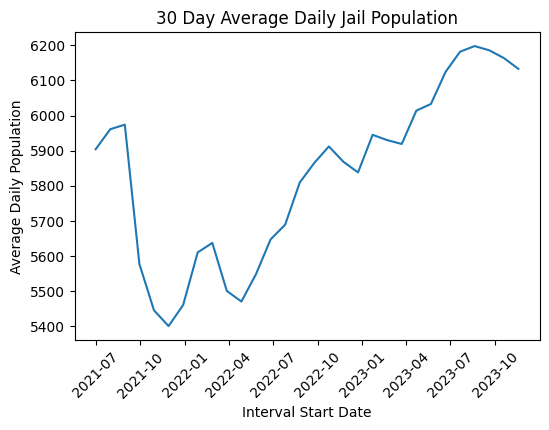

In [9]:
# Create the line plot
plt.figure(figsize = (6,4))

plt.plot(_30day_pop_tot['Start Date'], _30day_pop_tot['Total Population'])
plt.xticks(rotation=45)  # Set the x-axis tick labels

plt.xlabel('Interval Start Date')
# Set the y-axis label
plt.ylabel('Average Daily Population')

# Set the plot title
plt.title('30 Day Average Daily Jail Population')
# Display the plot
plt.show()

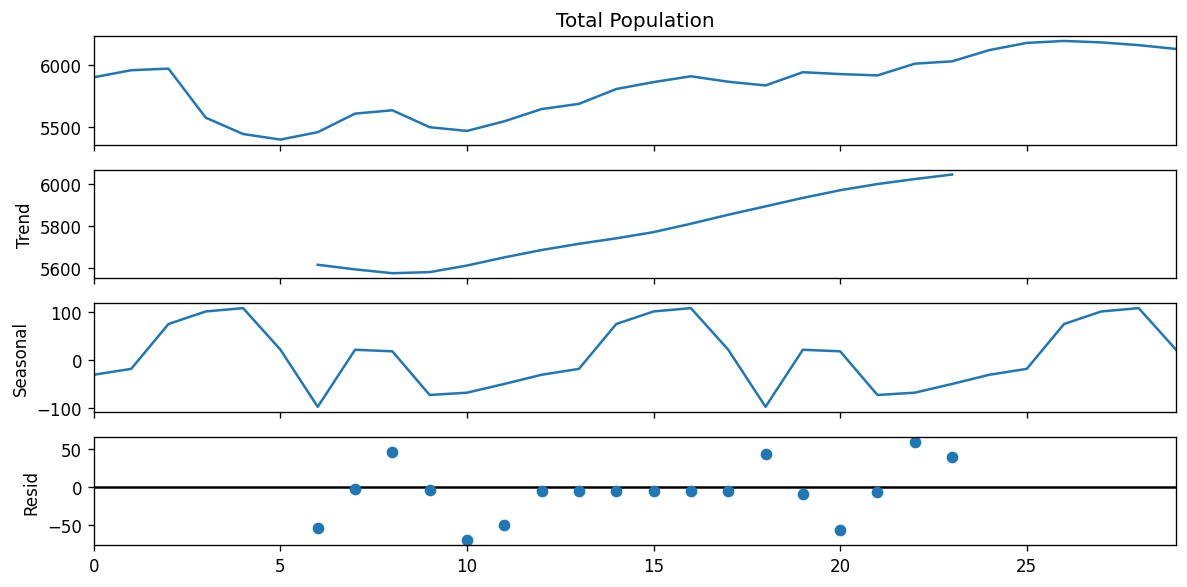

In [14]:
results = seasonal_decompose(_30day_pop_tot['Total Population'],model='additive',period=12)
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
# results.plot(xticks=monthly_counts['Year-Mo'].iloc[tick_positions])
results.plot()
# Save and display the plot
plt.show()

<Figure size 960x1800 with 0 Axes>

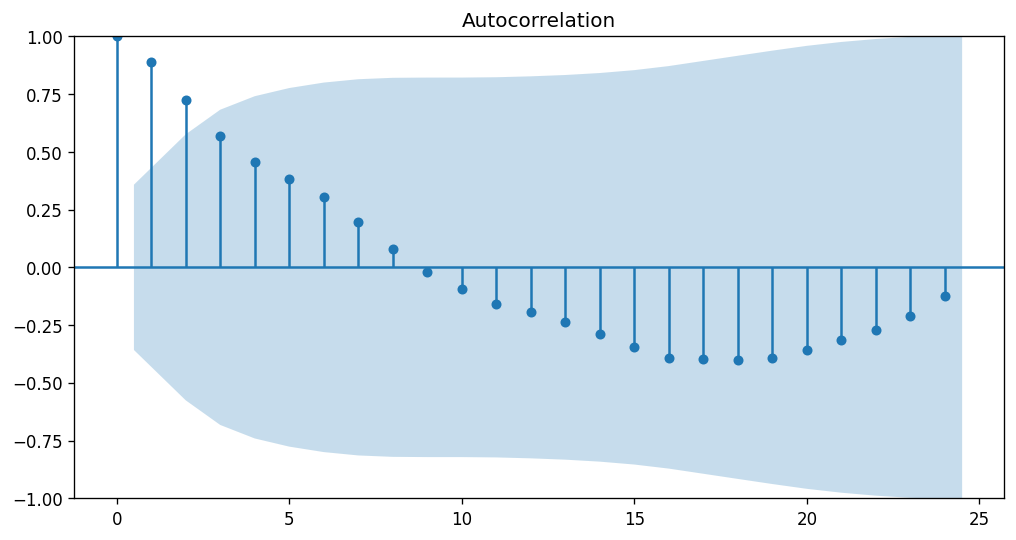

In [15]:
#plot autcorrelation for lags up to a year
plt.figure(figsize = (8,15))
plot_acf(_30day_pop_tot['Total Population'], lags = 24)
plt.show()

Text(0.5, 1.0, 'Partial Autocorrelation')

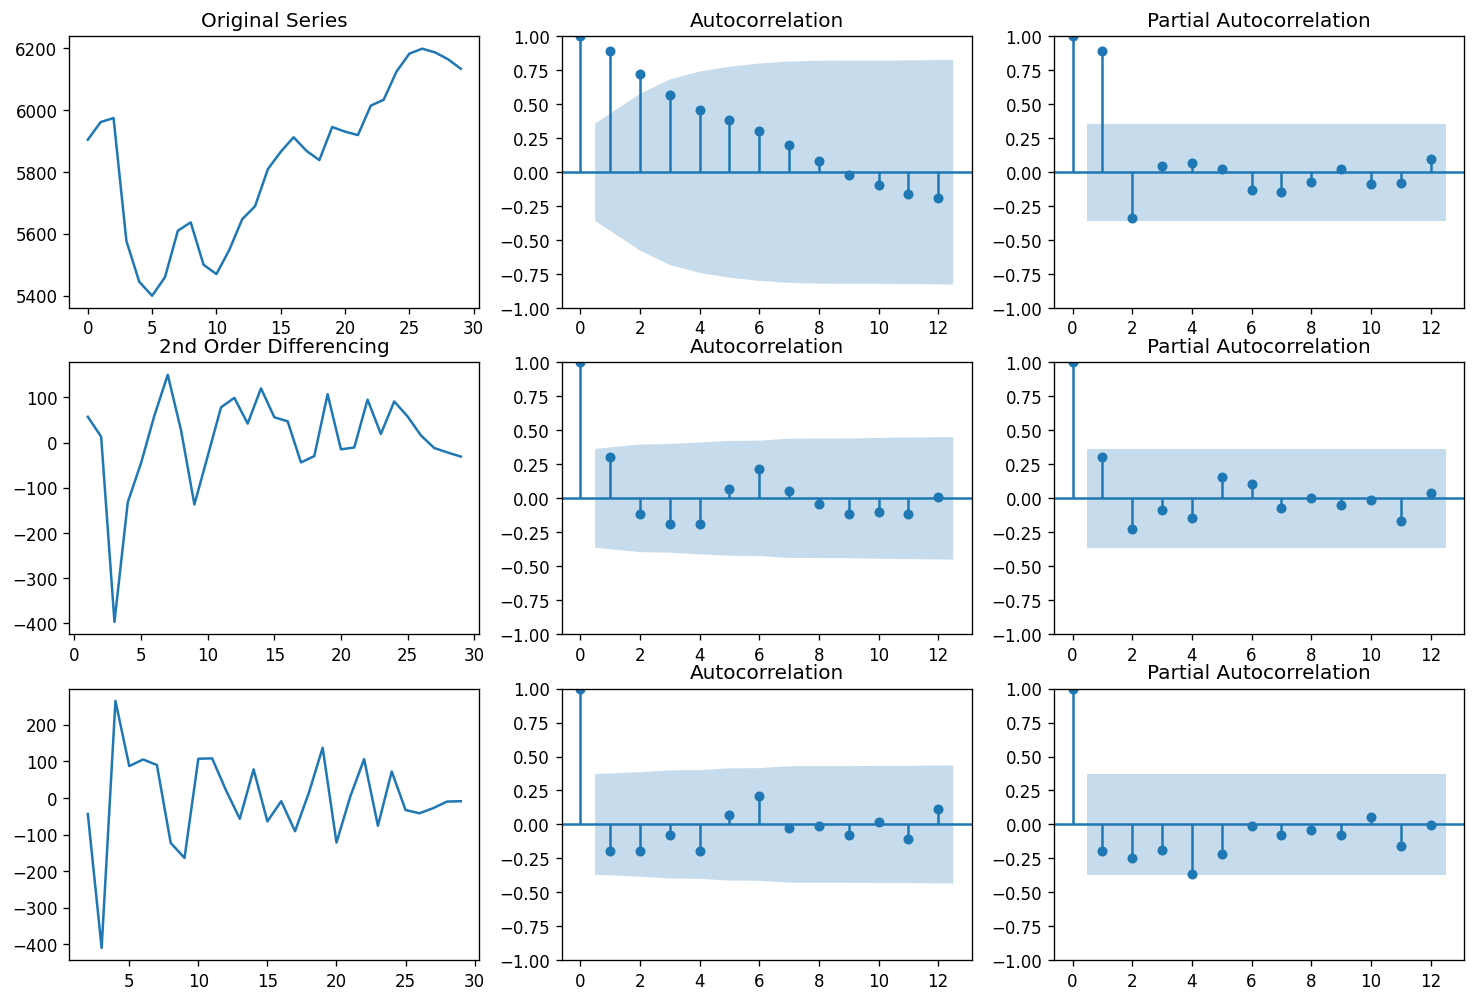

In [31]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 3)
axes[0, 0].plot(_30day_pop_tot['Total Population']); axes[0, 0].set_title('Original Series')

plot_acf(_30day_pop_tot['Total Population'], lags = 12, ax = axes[0, 1])
axes[0, 1].set_title('Autocorrelation')

plot_pacf(_30day_pop_tot['Total Population'], lags = 12, ax=axes[0, 2])
axes[0, 2].set_title('Partial Autocorrelation')


# 1st Differencing
axes[1, 0].plot(_30day_pop_tot['Total Population'].diff()); axes[1, 0].set_title('1st Order Differencing')

plot_acf(_30day_pop_tot['Total Population'].diff().dropna(), lags = 12, ax = axes[1, 1])
axes[1, 1].set_title('Autocorrelation')

plot_pacf(_30day_pop_tot['Total Population'].diff().dropna(), lags = 12, ax=axes[1, 2])
axes[1, 2].set_title('Partial Autocorrelation')

# 1st Differencing
axes[2, 0].plot(_30day_pop_tot['Total Population'].diff().dropna().diff().dropna()); axes[1, 0].set_title('2nd Order Differencing')

plot_acf(_30day_pop_tot['Total Population'].diff().dropna().diff().dropna(), lags = 12, ax = axes[2, 1])
axes[2, 1].set_title('Autocorrelation')

plot_pacf(_30day_pop_tot['Total Population'].diff().dropna().diff().dropna(), lags = 12, ax=axes[2, 2])
axes[2, 2].set_title('Partial Autocorrelation')

In [22]:
result = adfuller(_30day_pop_tot['Total Population'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.372721
p-value: 0.595282
Critical Values:
	1%: -3.689
	5%: -2.972
	10%: -2.625


In [24]:
result = adfuller(_30day_pop_tot['Total Population'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.856449
p-value: 0.050652
Critical Values:
	1%: -3.809
	5%: -3.022
	10%: -2.651


In [25]:
result = adfuller(_30day_pop_tot['Total Population'].diff().dropna().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.125846
p-value: 0.000000
Critical Values:
	1%: -3.700
	5%: -2.976
	10%: -2.628


In [33]:
from pmdarima.arima.utils import ndiffs

d = ndiffs(_30day_pop_tot['Total Population'], test='adf')
print('The optimal d coefficient with alpha = 0.05 is: ', d)

d = ndiffs(_30day_pop_tot['Total Population'], test='adf', alpha = 0.025)
print('The optimal d coefficient with alpha = 0.025 is: ', d)

The optimal d coefficient with alpha = 0.05 is:  1
The optimal d coefficient with alpha = 0.025 is:  2


### Rules for identifying the numbers of AR and MA terms:

* Rule 1: If the partial autocorrelation function (PACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "underdifferenced"--then consider adding one or more AR terms to the model. The lag beyond which the PACF cuts off is the indicated number of AR terms.

* Rule 2: If the autocorrelation function (ACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag beyond which the ACF cuts off is the indicated number of MA terms.

* Rule 3: It is possible for an AR term and an MA term to cancel each other's effects, so if a mixed AR-MA model seems to fit the data, also try a model with one fewer AR term and one fewer MA term--particularly if the parameter estimates in the original model require more than 10 iterations to converge. BEWARE OF USING MULTIPLE AR TERMS AND MULTIPLE MA TERMS IN THE SAME MODEL.


Based on the descriptive analysis above, if the timeseries is differenced by a degree of 1 then we need AR(1). However, if we have a difference degree of 2 we use MA(1). Lets try these two models out and optimize on AIC.

Recall that:

* **p:** The size of the moving average window, or the number of the moving average terms, also called the order of moving average.

* **q:** The number of AR terms included in the model, also called the lag order.

In [62]:
# d = 1 and AR = 1
P=0
D=1
Q=1

# fit model
series = _30day_pop_tot['Total Population']

model = sm.tsa.ARIMA(series, order=(Q,D,P))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:       Total Population   No. Observations:                   30
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -173.788
Date:                Mon, 18 Dec 2023   AIC                            351.577
Time:                        13:40:08   BIC                            354.311
Sample:                             0   HQIC                           352.433
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3074      0.599      0.513      0.608      -0.866       1.481
sigma2      9402.9722   1184.400      7.939      0.000    7081.592    1.17e+04
Ljung-Box (L1) (Q):                   0.14   Jarque-

In [38]:
# d = 2 and AM = 1
P=1
D=2
Q=0

# fit model
series = _30day_pop_tot['Total Population']

model = sm.tsa.ARIMA(series, order=(Q,D,P))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:       Total Population   No. Observations:                   30
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -171.766
Date:                Mon, 18 Dec 2023   AIC                            347.532
Time:                        10:50:49   BIC                            350.196
Sample:                             0   HQIC                           348.346
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9937      2.129     -0.467      0.641      -5.167       3.180
sigma2      1.067e+04   2.24e+04      0.477      0.634   -3.32e+04    5.45e+04
Ljung-Box (L1) (Q):                   3.85   Jarque-

In [36]:
#Lets try to incorporate seasonality to see if the results are better
# d = 1 and AR = 1
P=0
D=1
Q=1

model = sm.tsa.SARIMAX(series, order=(Q,D,P),seasonal_order=(Q,D,P,12))
model_fit = model.fit()
print(model_fit.summary())


                                     SARIMAX Results                                      
Dep. Variable:                   Total Population   No. Observations:                   30
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -105.565
Date:                            Mon, 18 Dec 2023   AIC                            217.131
Time:                                    10:49:48   BIC                            219.630
Sample:                                         0   HQIC                           217.379
                                             - 30                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4041      0.584      0.692      0.489      -0.741       1.549
ar.S.L12      -0.2082      0.553   

In [39]:
# d = 1 and AR = 1
P=1
D=2
Q=0

model = sm.tsa.SARIMAX(series, order=(Q,D,P),seasonal_order=(Q,D,P,12))
model_fit = model.fit()
print(model_fit.summary())

c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                   Total Population   No. Observations:                   30
Model:             SARIMAX(0, 2, 1)x(0, 2, 1, 12)   Log Likelihood                 -27.394
Date:                            Mon, 18 Dec 2023   AIC                             60.789
Time:                                    10:51:16   BIC                             58.948
Sample:                                         0   HQIC                            56.749
                                             - 30                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3675     11.364      0.032      0.974     -21.905      22.640
ma.S.L12      -0.9831    338.324   

c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3159: UserWarning: Early subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(
c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3159: UserWarning: Later subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(


In [40]:
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# Step 2: Determine stationarity and find differencing degree
d = ndiffs(series, test='adf')
print(d)
# Step 3: Iterate through ARIMA models to find the optimal one
best_mse = float('inf')
best_order = None

for p in range(5):
    for q in range(5):
        try:
            model = ARIMA(train, order=(p, d, q))
            results = model.fit(method_kwargs={'warn_convergence': False})
            pred = results.get_forecast(steps=len(test))
            mse = mean_squared_error(test, pred.predicted_mean)

            if mse < best_mse:
                best_mse = mse
                best_order = (p, d, q)

        except:
            continue
print(best_order, best_mse)

1


c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting auto

(1, 1, 0) 16170.798390999786


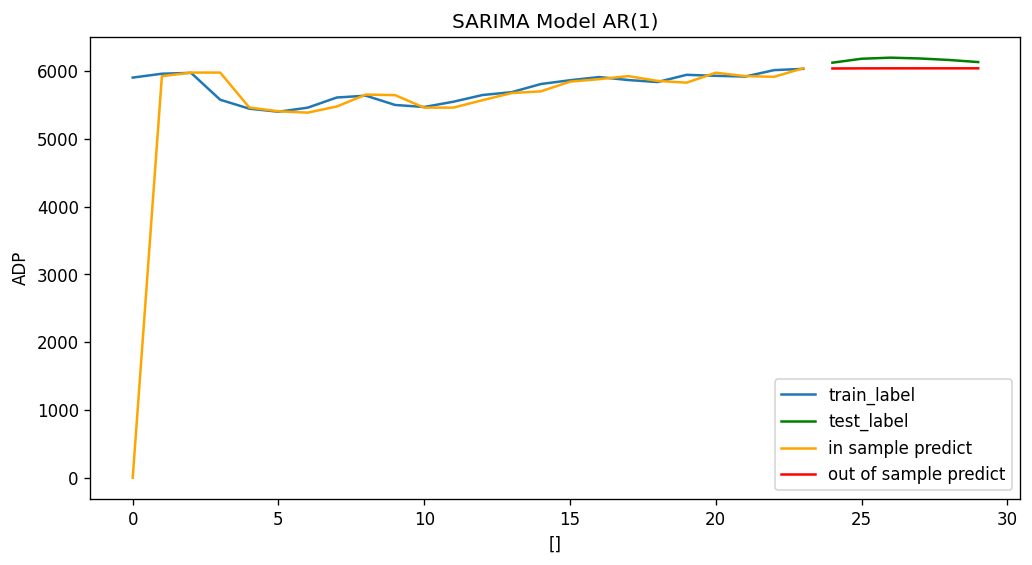

In [60]:
#plot
#fit 
model = ARIMA(train, order=best_order)
results = model.fit(method_kwargs={'warn_convergence': False})
# Perform in-sample predictions
train_predictions = results.predict()
pred = results.get_forecast(steps=len(test))
fc_series = pd.Series(pred.summary_frame()['mean'].values)

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(train.index,train,label='train_label') # train
ax.plot(test.index,test,color='green',label='test_label') # test
ax.plot(train.index,train_predictions,color='orange',label='in sample predict') # in-sample
ax.plot(test.index,fc_series,color='red',label='out of sample predict') # out of sample

plt.xlabel([])
plt.ylabel('ADP')
plt.title('SARIMA Model AR(1)')
plt.legend()
plt.show()

The Autoregressive ARIMA model with just 1 lag component is not helpful for forecasting 12 timestamps in the future. Lets check to see which GLM would be best given our data.

1. Poisson Distribution assumes $E[Y] = Var[Y] = \lambda$

2. Negative Binomial Regression which assumes $Var[Y] = E[Y] + \alpha \cdot E[Y]$

In [63]:
#check mean and variance of dataset
mu = train.mean()
var = train.var()

print(f'The training set has a mean of {mu} and variance of {var}')

The training set has a mean of 5748.125 and variance of 43029.33152173913


Based on the results above, our jail population dataset does not follow a Poisson distribution. Lets try Negative Binomial Regression

In [143]:
#add date related regressors
_30day_pop_tot['Month'] = _30day_pop_tot['Start Date'].dt.month
_30day_pop_tot['Year'] = _30day_pop_tot['Start Date'].dt.year
_30day_pop_tot = _30day_pop_tot.rename(columns={'Total Population': 'Total_Population'})
#add lag terms
_30day_pop_tot['adp_lag1'] = _30day_pop_tot['Total_Population'].shift(1)
_30day_pop_tot['adp_lag2'] = _30day_pop_tot['Total_Population'].shift(2)
_30day_pop_tot['adp_lag3'] = _30day_pop_tot['Total_Population'].shift(3)
_30day_pop_tot['adp_lag4'] = _30day_pop_tot['Total_Population'].shift(4)
_30day_pop_tot['adp_lag12'] = _30day_pop_tot['Total_Population'].shift(12)


#fillnas with zero
_30day_pop_tot = _30day_pop_tot.fillna(0)
_30day_pop_tot.head()

,Start Date,End Date,Total_Population,Month,Year,adp_lag1,adp_lag2,adp_lag3,adp_lag4,adp_lag12
0,2021-07-01 00:00:00-04:00,2021-07-30 00:00:00-04:00,5904.0,7,2021,0.0,0.0,0.0,0.0,0.0
1,2021-07-31 00:00:00-04:00,2021-08-29 00:00:00-04:00,5961.0,7,2021,5904.0,0.0,0.0,0.0,0.0
2,2021-08-30 00:00:00-04:00,2021-09-28 00:00:00-04:00,5974.0,8,2021,5961.0,5904.0,0.0,0.0,0.0
3,2021-09-29 00:00:00-04:00,2021-10-28 00:00:00-04:00,5577.0,9,2021,5974.0,5961.0,5904.0,0.0,0.0
4,2021-10-29 00:00:00-04:00,2021-11-27 00:00:00-05:00,5445.0,10,2021,5577.0,5974.0,5961.0,5904.0,0.0


In [144]:
#create the training and testing data sets
train_size = int(len(series) * 0.8)
# train_size = 28
df_train = _30day_pop_tot.iloc[:train_size]
df_test = _30day_pop_tot.iloc[train_size:]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=24
Testing data set length=6


In [148]:
from patsy import dmatrices

#Setup the regression expression in patsy notation
expr = """Total_Population ~ Month + Year + adp_lag3 + adp_lag4"""

#Set up the X and y matrices for the training and testing data sets
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')


In [149]:
#Using the statsmodels GLM class, train the Poisson regression model on the training data set
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_training_results.summary())

#print out the fitted rate vector
print(poisson_training_results.mu)

                 Generalized Linear Model Regression Results                  
Dep. Variable:       Total_Population   No. Observations:                   24
Model:                            GLM   Df Residuals:                       19
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -133.57
Date:                Mon, 18 Dec 2023   Deviance:                       15.286
Time:                        16:48:38   Pearson chi2:                     15.3
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9986
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -140.7030     13.057    -10.776      0.0

           mean    mean_se  mean_ci_lower  mean_ci_upper
24  6078.991956  36.790852    6007.309201    6151.530071
25  6112.670332  40.925655    6032.981519    6193.411743
26  6147.982108  45.453642    6059.536962    6237.718201
27  6181.072328  50.600660    6082.688255    6281.047708
28  6213.856336  55.941846    6105.174007    6324.473394
29  6251.596047  61.806485    6131.623681    6373.915812


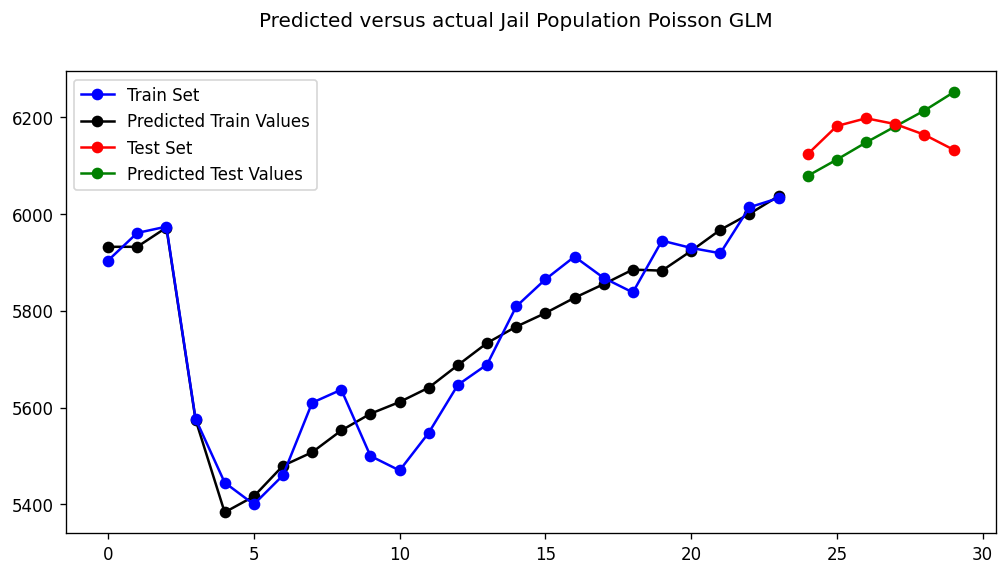

In [150]:
#make some predictions using our trained NB2 model
poisson_predictions = poisson_training_results.get_prediction(X_test)

#print out the predictions
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

#plot the predicted counts versus the actual counts for the test data
IS_predicted_counts = poisson_training_results.predict(X_train)
OS_predicted_counts = predictions_summary_frame['mean']
actual_counts = y_test['Total_Population']
fig = plt.figure()
fig.suptitle('Predicted versus actual Jail Population Poisson GLM')
predicted_train, = plt.plot(X_train.index, IS_predicted_counts, 'ko-', label='Predicted Train Values')
train_set, = plt.plot(X_train.index, y_train['Total_Population'], 'bo-', label='Train Set')
predicted_test, = plt.plot(X_test.index, OS_predicted_counts, 'go-', label='Predicted Test Values')
test_set, = plt.plot(X_test.index, actual_counts, 'ro-', label='Test Set')
plt.legend(handles=[train_set,predicted_train, test_set, predicted_test])
plt.show()

In [122]:
#Add the λ vector as a new column called 'BB_LAMBDA' to the Data Frame of the training data set
df_train['ADP_LAMBDA'] = poisson_training_results.mu

#add a derived column called 'AUX_OLS_DEP' to the pandas Data Frame. This new column will store the values of the dependent variable of the OLS regression
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['Total_Population'] - x['ADP_LAMBDA'])**2 - x['ADP_LAMBDA']) / x['ADP_LAMBDA'], axis=1)

#use patsy to form the model specification for the OLSR
ols_expr = """AUX_OLS_DEP ~ ADP_LAMBDA - 1"""

#Configure and fit the OLSR model
aux_olsr_results = smf.ols(ols_expr, df_train).fit()

C:\Users\emjoh\AppData\Local\Temp\ipykernel_40688\462518319.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['ADP_LAMBDA'] = poisson_training_results.mu
C:\Users\emjoh\AppData\Local\Temp\ipykernel_40688\462518319.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['Total_Population'] - x['ADP_LAMBDA'])**2 - x['ADP_LAMBDA']) / x['ADP_LAMBDA'], axis=1)


In [123]:
#Print the regression params
print(aux_olsr_results.params)

ADP_LAMBDA   -0.000068
dtype: float64


If the value of $\alpha$ (ADP_LAMBDA) is statistically not significant, then the Negative Binomial regression model cannot do a better job of fitting the training data set than a Poisson regression model. To check whether or not $\alpha$ is statistically significant or not, we will extract the t-value from the OLS result and use a [t-value calculator](https://goodcalculators.com/student-t-value-calculator/) to determine with `degrees of freedom = len(df_train) - 1 = 23` what the critical t-value is.

t-value at a 95% confidence level (right-tailed) & df = 23: 1.714

t-value at a 95% confidence level (two-tailed) & df = 23: +/- 2.068

In [124]:
aux_olsr_results.tvalues

ADP_LAMBDA   -2.306331
dtype: float64

The t-statistic of $\alpha$ is below the t-value found with 95% confidence and df = 23. Therefore it is not statistically significant and the NB GLM with this alpha value is no better than the Poisson Distribution.

In [125]:
#train the NB2 model on the training data set
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

#print the training summary
print(nb2_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       Total_Population   No. Observations:                   24
Model:                            GLM   Df Residuals:                       17
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 18 Dec 2023   Deviance:                       24.154
Time:                        16:25:56   Pearson chi2:                     24.1
No. Iterations:                     3   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -139.8143     10.343    -13.518      0.0

c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\genmod\families\family.py:1454: RuntimeWarning: invalid value encountered in log
  ll_obs = endog * np.log(self.alpha * mu)


In [126]:
#make some predictions using our trained NB2 model
nb2_predictions = nb2_training_results.get_prediction(X_test)

#print out the predictions
predictions_summary_frame = nb2_predictions.summary_frame()
print(predictions_summary_frame)

           mean    mean_se  mean_ci_lower  mean_ci_upper
24  6079.047226  28.495648    6023.452559    6135.155016
25  6113.456623  31.771045    6051.502579    6176.044939
26  6148.853572  35.286588    6080.080624    6218.404424
27  6181.587481  39.328429    6104.983781    6259.152384
28  6213.957630  43.542304    6129.199640    6299.887701
29  6251.302400  48.179355    6157.582233    6346.449015


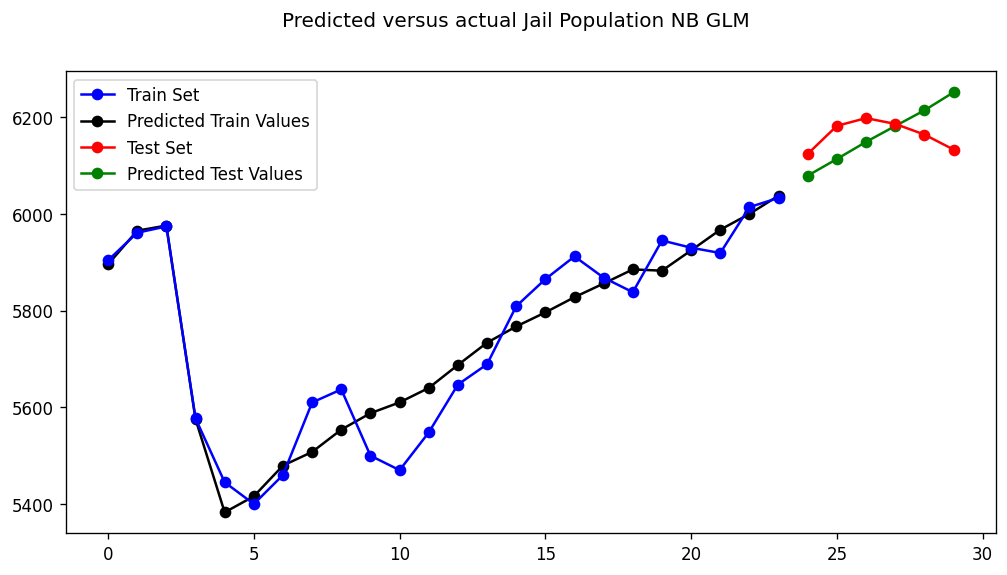

In [127]:
#plot the predicted counts versus the actual counts for the test data
IS_predicted_counts = nb2_training_results.predict(X_train)
OS_predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['Total_Population']
fig = plt.figure()
fig.suptitle('Predicted versus actual Jail Population NB GLM')
predicted_train, = plt.plot(X_train.index, IS_predicted_counts, 'ko-', label='Predicted Train Values')
train_set, = plt.plot(X_train.index, y_train['Total_Population'], 'bo-', label='Train Set')
predicted_test, = plt.plot(X_test.index, OS_predicted_counts, 'go-', label='Predicted Test Values')
test_set, = plt.plot(X_test.index, actual_counts, 'ro-', label='Test Set')
plt.legend(handles=[train_set,predicted_train, test_set, predicted_test])
plt.show()

## Bayesian Dynamic Linear Model

Using PyDLM package in python.

In [154]:
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason

In [155]:
ts_data = series
ts_data.head()

0    5904.0
1    5961.0
2    5974.0
3    5577.0
4    5445.0
Name: Total Population, dtype: float64

In [200]:
myDLM = dlm(ts_data)
linear_trend = trend(degree=1, discount=0.95, name='trend1')
AR4 = autoReg(degree=4, discount=0.99, name='ar4', w=1e7)
# yearly_seasonality = seasonality(period=12, discount=0.99, name='year')
myDLM = myDLM + linear_trend + AR4

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


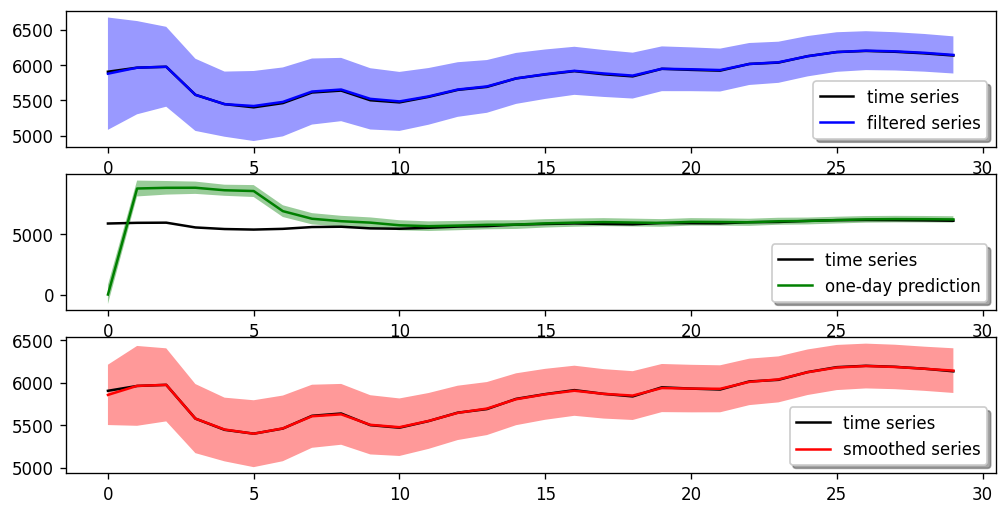

In [201]:
myDLM.fit()
myDLM.plot()


In [202]:
myDLM.getMSE()


2875170.3114425144

In [203]:
myDLM.ls()

The static components are
trend1 (degree = 2)
 
There is no dynamic component.
 
The automatic components are
ar4 (dimension = 4)


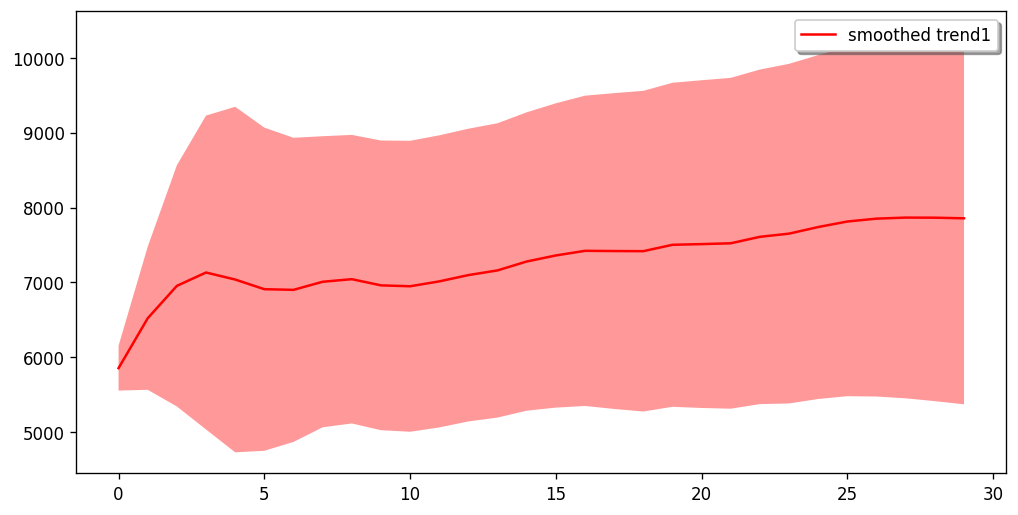

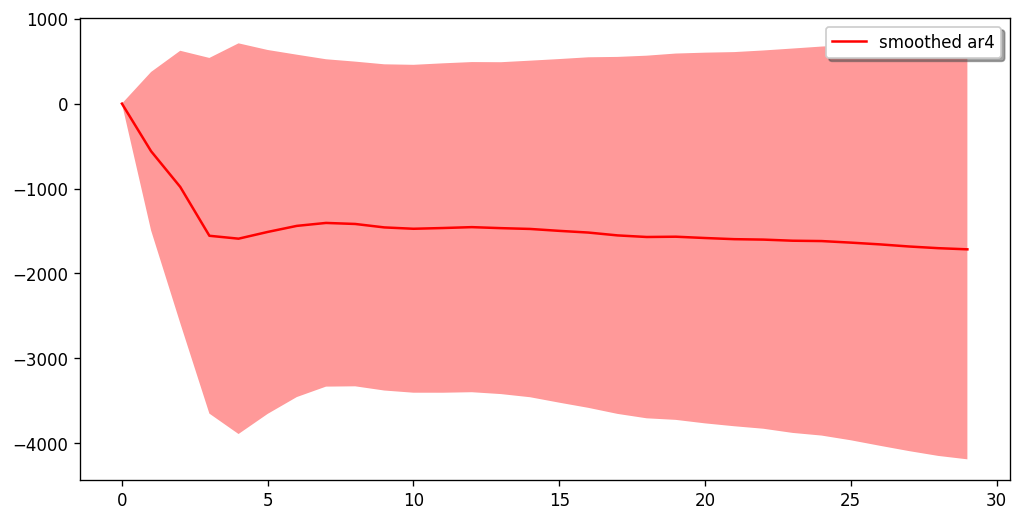

In [205]:
# Plot each component (attribute the time series to each component)
myDLM.turnOff('filtered plot')
myDLM.turnOff('predict plot')
myDLM.plot('trend1')
myDLM.plot('ar4')

To further verify the performance, we use this simple model for long-term forecasting. In particular, we use the previous 24 months of data to forecast the next 6 months.

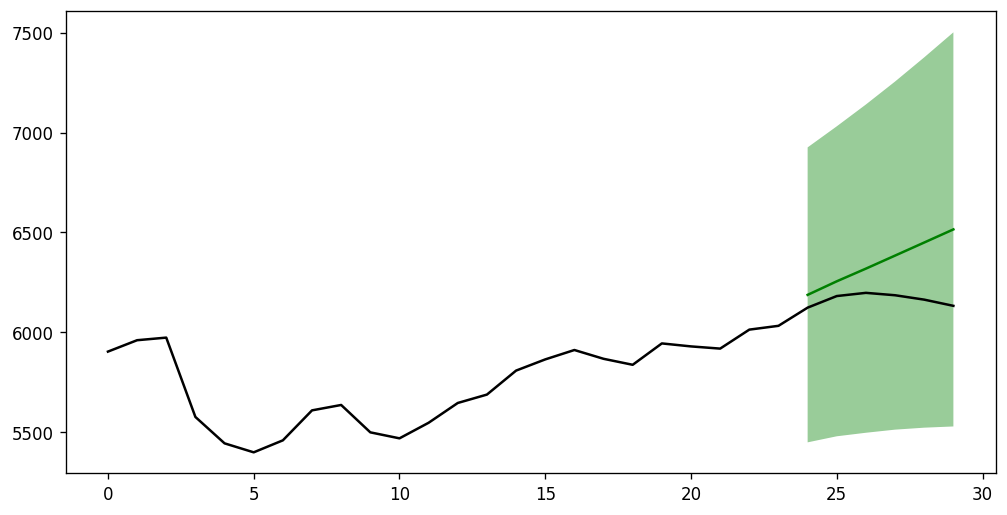

In [206]:
myDLM.plotPredictN(date=24, N=6)

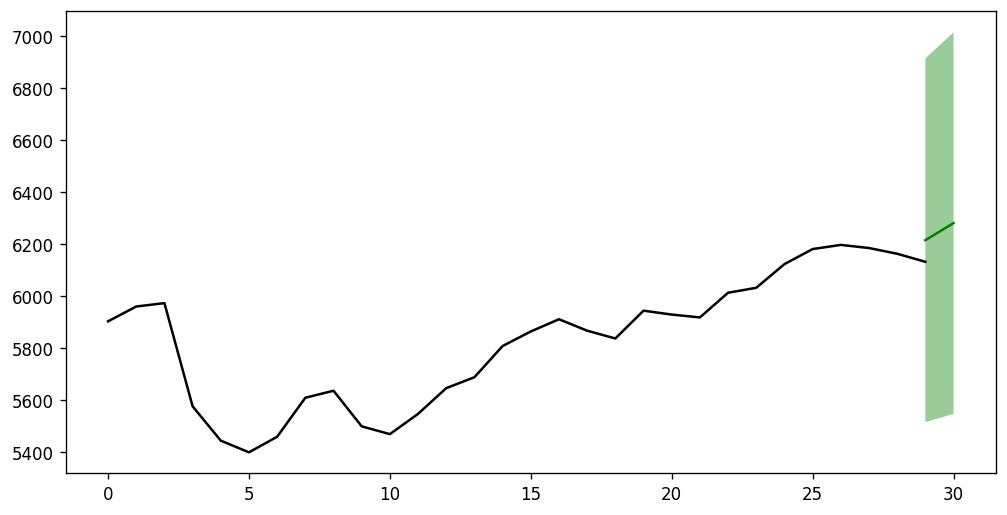

In [209]:
myDLM.plotPredictN(date=29, N=2)

In [170]:
from pydlm import modelTuner

In [171]:
myTuner = modelTuner(method='gradient_descent', loss='mse')
tunedDLM = myTuner.tune(myDLM, maxit=100)
#fit tuned model
myDLM_mse = myDLM.getMSE()
tunedDLM.fit()
tunedDLM_mse = tunedDLM.getMSE()

The algorithm stops without converging.
Possible reason: some discount is too close to 1 or 0.7 (0.7 is smallest discount that is permissible.


In [173]:
print(tunedDLM_mse,myDLM.getMSE())

1758482.495335009 1747037.9886882787


In [174]:
myDLM.tune()
print(tunedDLM_mse,myDLM.getMSE())

Starting forward filtering...
Forward filtering completed.
The current mse is 1747037.9886882787.
The algorithm stops without converging.
Possible reason: some discount is too close to 1 or 0.7 (0.7 is smallest discount that is permissible.
Starting forward filtering...
Forward filtering completed.
The new mse is 1758482.495335009.
1758482.495335009 1758482.495335009


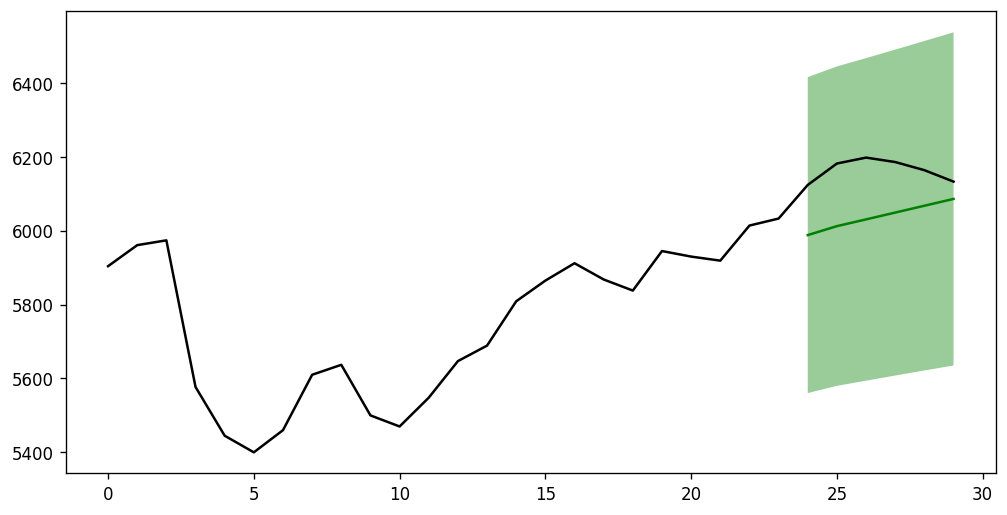

In [175]:
myDLM.plotPredictN(date=24, N=6)

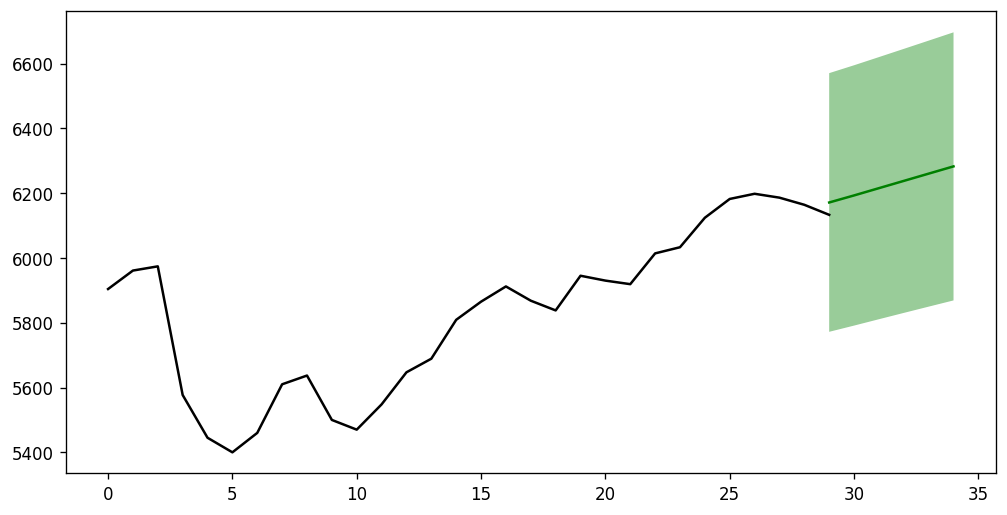

In [177]:
myDLM.plotPredictN(date=29, N=6)